In [1]:
import networkx as nx
import pandas as pd
import os
import numpy as np
from itertools import combinations
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [2]:
leadership_path = r'C:\Projects\connecteddatahub\data\cleaned_dataframes\master_leadershipdata_validated.csv'
data_path = r'C:\Projects\connecteddatahub\data'
leadership_df = pd.read_csv(leadership_path)
print(leadership_df.columns)

Index(['Year', 'Name', 'Position', 'Institution', 'SubInstitution',
       'Education', 'FixedPosition', 'Seniority', 'Designation',
       'AffiliationId', 'carnegie_id', 'SystemId', 'RawName', 'RawInstitution',
       'RawPosition', 'FirstName', 'MiddleName', 'LastName', 'NickName',
       'SuffixName', 'PrefixName', 'MiddleInitials', 'RawName4Match',
       'LeaderId'],
      dtype='object')


In [3]:
board_df =  leadership_df[leadership_df['FixedPosition'] == 'Board Member']
# board_df = leadership_df[
#     leadership_df['FixedPosition'].str.contains('Board Member', na=False)
# ]

print(board_df.shape)

(54697, 24)


In [4]:
def _eigvec_centrality_componentwise(G, weight="WeightNorm", max_iter=2000, tol=1e-07):
    """
    Eigenvector centrality for disconnected graphs
    Run per connected component (undirected), weighted if available.
    Isolated nodes get 0

    there are a ton of try catch here - was having issues with the graph not being fully connected but each
    time i was trying to extract just one of the blocks i would run into an issue
    """

    if G.number_of_nodes() == 0:
        return {}

    scores = {n: 0.0 for n in G.nodes()}  # default for isolates / tiny comps

    for comp_nodes in nx.connected_components(G):
        H = G.subgraph(comp_nodes).copy()
        # If the component has no edges (single node), leave score=0.0
        if H.number_of_edges() == 0:
            continue
        # Try numpy (fast, stable on connected graphs)
        try:
            part = nx.eigenvector_centrality_numpy(H, weight=weight)
        except nx.AmbiguousSolution:
            # Shouldn't happen per-component, but keep belt-and-suspenders
            part = nx.eigenvector_centrality(H, weight=weight, max_iter=max_iter, tol=tol)
        except Exception:
            # Fallback to power iteration with relaxed params
            part = nx.eigenvector_centrality(H, weight=weight, max_iter=max_iter, tol=tol)
        # Write back
        for n, v in part.items():
            scores[n] = float(v)

    return scores

def _shannon_entropy_bits(values):
    """Base-2 Shannon entropy over nonnegative weights."""
    vals = np.asarray(list(values), dtype=float)
    s = vals.sum()
    if s <= 0 or vals.size == 0:
        return 0.0
    p = vals / s
    p = p[p > 0]
    return float(-np.sum(p * np.log2(p)))


In [5]:
'''Original code for interlock graph - weakness is very skewed'''

# def build_interlock_graphs(board_df):
#     """Create node and edge DataFrames for yearly interlocks."""
#     interlocks = []

#     # person-level pairing
#     for (year, first, last), person_data in board_df.groupby(["Year", "FirstName", "LastName"]):
#         affiliations = person_data[["AffiliationId", "Institution", "SystemId"]].drop_duplicates()
#         if len(affiliations) <= 1:
#             continue

#         for (id1, inst1, sys1), (id2, inst2, sys2) in combinations(affiliations.values, 2):
#             # Skip if both belong to the same system
#             if pd.notna(sys1) and pd.notna(sys2) and sys1 == sys2:
#                 continue

#             # Canonicalize undirected edge
#             u, v = sorted((id1, id2))
#             interlocks.append({
#                 "Year": year,
#                 "AffiliationId_1": u,
#                 "AffiliationId_2": v,
#                 "Institution_1": inst1 if u == id1 else inst2,
#                 "Institution_2": inst2 if u == id1 else inst1,
#                 "SystemId_1": sys1 if u == id1 else sys2,
#                 "SystemId_2": sys2 if u == id1 else sys1,
#             })

#     edges = pd.DataFrame(interlocks)

#     # edge aggregation
#     edges = (
#         edges.groupby(["Year", "AffiliationId_1", "Institution_1",
#                        "AffiliationId_2", "Institution_2"], as_index=False)
#         .size()
#         .rename(columns={"size": "InterlockCount"})
#     )

#     # board sizes and normalized weight
#     board_sizes = (
#         board_df.groupby(["Year", "AffiliationId"])["Name"]
#         .nunique()
#         .reset_index(name="BoardSize")
#     )

#     edges = edges.merge(
#         board_sizes.rename(columns={"AffiliationId": "AffiliationId_1", "BoardSize": "BoardSize_1"}),
#         on=["Year", "AffiliationId_1"], how="left"
#     ).merge(
#         board_sizes.rename(columns={"AffiliationId": "AffiliationId_2", "BoardSize": "BoardSize_2"}),
#         on=["Year", "AffiliationId_2"], how="left"
#     )

#     edges["WeightNorm"] = edges["InterlockCount"] / (
#         edges["BoardSize_1"] + edges["BoardSize_2"]
#     )

#     # node list (year-invariant; we'll add per-year metrics later)
#     nodes = (
#         board_df[["AffiliationId", "Institution", "SystemId"]]
#         .drop_duplicates()
#         .rename(columns={"AffiliationId": "Id", "Institution": "Label"})
#     )

#     return edges, nodes


# def compute_edge_weakness(G, alpha=0.7, beta=0.3):
#     """Assign weakness to each edge as 0.7*(1 - overlap) + 0.3*betweenness."""
#     # neighborhood overlap
#     overlap = {}
#     for u, v in G.edges():
#         Nu, Nv = set(G.neighbors(u)) - {v}, set(G.neighbors(v)) - {u}
#         inter = len(Nu & Nv)
#         denom = len(Nu | Nv)
#         overlap[(u, v)] = inter / (denom - 2) if denom > 2 else 0.0
#     nx.set_edge_attributes(G, overlap, "overlap")

#     # edge betweenness
#     betweenness = nx.edge_betweenness_centrality(G, normalized=True)
#     nx.set_edge_attributes(G, betweenness, "betweenness")

#     # combined weakness
#     weakness = {
#         (u, v): alpha * (1 - d.get("overlap", 0.0)) + beta * d.get("betweenness", 0.0)
#         for u, v, d in G.edges(data=True)
#     }
#     nx.set_edge_attributes(G, weakness, "weakness")
#     return weakness


# def attach_weakness(edges, nodes, alpha=0.7, beta=0.3):
#     """
#     Compute and attach edge weaknesses for each year.
#     Ensures canonical ordering (min, max) for merge alignment.
#     """
#     edges = edges.copy()
#     edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
#     edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

#     all_weakness = []

#     for year, group in edges.groupby("Year", sort=False):

#         # Build undirected graph from this year's edges
#         G = nx.from_pandas_edgelist(
#             group,
#             source="AffiliationId_1",
#             target="AffiliationId_2",
#             edge_attr="WeightNorm",
#             create_using=nx.Graph(),
#         )

#         compute_edge_weakness(G, alpha, beta)

#         rows = []
#         for u, v, d in G.edges(data=True):
#             a, b = (u, v) if u <= v else (v, u)
#             rows.append({
#                 "Year": year,
#                 "AffiliationId_1": a,
#                 "AffiliationId_2": b,
#                 "Weakness": d.get("weakness", np.nan)
#             })
#         all_weakness.append(pd.DataFrame(rows))

#     if not all_weakness:
#         edges["Weakness"] = np.nan
#         return edges

#     weakness_df = pd.concat(all_weakness, ignore_index=True)

#     out = edges.merge(
#         weakness_df,
#         on=["Year", "AffiliationId_1", "AffiliationId_2"],
#         how="left"
#     )
#     return out


# def attach_node_metrics(edges, nodes, weight_col="WeightNorm"):
#     """
#     Compute node metrics per year and return updated df
#     """


#     edges = edges.copy()
#     edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
#     edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

#     out = []

#     for year, gdf in edges.groupby("Year", sort=False):
#         if gdf.empty:
#             continue

#         edge_attr = [weight_col] if (weight_col in gdf.columns) else None
#         G = nx.from_pandas_edgelist(
#             gdf,
#             source="AffiliationId_1",
#             target="AffiliationId_2",
#             edge_attr=edge_attr,
#             create_using=nx.Graph()
#         )
#         if G.number_of_nodes() == 0:
#             continue

#         # Degree & degree centrality
#         degree = dict(G.degree())
#         degree_c = nx.degree_centrality(G)

#         eig_c = _eigvec_centrality_componentwise(G, weight=weight_col, max_iter=2000, tol=1e-7)
#         betw = nx.betweenness_centrality(G, normalized=True)

#         # Local clustering (unweighted)
#         clust = nx.clustering(G)

#         # modularity -> integer community labels
#         communities = list(nx.algorithms.community.greedy_modularity_communities(G, weight=weight_col))
#         node2comm = {}
#         for cid, comm in enumerate(communities):
#             for n in comm:
#                 node2comm[n] = cid

#         # Strength + entropy over incident weights
#         strength = {}
#         entropy_bits = {}
#         for n in G.nodes():
#             nbr_w = [float(G[n][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(n)]
#             strength[n] = float(np.sum(nbr_w)) if nbr_w else 0.0
#             entropy_bits[n] = _shannon_entropy_bits(nbr_w)

#         # Assemble rows (Year, Id)
#         rows = []
#         for n in G.nodes():
#             rows.append({
#                 "Year": year,
#                 "Id": n,
#                 "degree": degree.get(n, 0),
#                 "degree_centrality": degree_c.get(n, 0.0),
#                 "eigenvector_centrality": eig_c.get(n, 0.0),
#                 "betweenness_centrality": betw.get(n, 0.0),
#                 "clustering": clust.get(n, 0.0),
#                 "modularity_class": node2comm.get(n, -1),
#                 "interlock_entropy_bits": entropy_bits.get(n, 0.0),
#                 "strength": strength.get(n, 0.0),
#             })
#         out.append(pd.DataFrame(rows))

#     metrics = pd.concat(out, ignore_index=True)

#     # Join node attributes (Label, SystemId) -> single nodes_df with Year granularity
#     node_attrs = nodes[["Id", "Label", "SystemId"]].drop_duplicates()
#     nodes_updated = (
#         metrics.merge(node_attrs, on="Id", how="left")
#         .reindex(columns=["Year","Id","Label","SystemId",
#                           "degree","degree_centrality","eigenvector_centrality",
#                           "betweenness_centrality","clustering","modularity_class",
#                           "interlock_entropy_bits","strength"])
#         .sort_values(["Year","Id"], kind="mergesort")
#         .reset_index(drop=True)
#     )
#     return nodes_updated


# def attach_edge_entropy(edges, weight_col="WeightNorm", out_col="EdgeEntropyBits"):
#     """
#     Compute edge-level local entropy around endpoints and return UPDATED edges DF.
#     For each (Year, u, v): H( concat( weights(u,·\{v}), weights(v,·\{u}) ) ).
#     If no neighbors besides each other, entropy=0.
#     """
#     if edges.empty:
#         edges[out_col] = np.nan
#         return edges

#     edges = edges.copy()
#     edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
#     edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

#     out_chunks = []
#     for year, gdf in edges.groupby("Year", sort=False):
#         edge_attr = [weight_col] if (weight_col in gdf.columns) else None
#         G = nx.from_pandas_edgelist(
#             gdf,
#             source="AffiliationId_1",
#             target="AffiliationId_2",
#             edge_attr=edge_attr,
#             create_using=nx.Graph()
#         )
#         if G.number_of_edges() == 0:
#             # nothing; fill 0 for this year's edges
#             tmp = gdf.copy()
#             tmp[out_col] = 0.0
#             out_chunks.append(tmp)
#             continue

#         ent_map = {}
#         for u, v in G.edges():
#             # neighbors around u and v (excluding the counterpart)
#             wu = [float(G[u][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(u) if nbr != v]
#             wv = [float(G[v][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(v) if nbr != u]
#             ent_map[(min(u, v), max(u, v))] = _shannon_entropy_bits(wu + wv)

#         tmp = gdf.copy()
#         tmp[out_col] = [
#             ent_map.get((min(u, v), max(u, v)), 0.0)
#             for u, v in zip(tmp["AffiliationId_1"], tmp["AffiliationId_2"])
#         ]
#         out_chunks.append(tmp)

#     return pd.concat(out_chunks, ignore_index=True)


'Original code for interlock graph - weakness is very skewed'

In [6]:

def build_interlock_graphs(board_df):
    """Create node and edge DataFrames for yearly interlocks."""
    interlocks = []

    # person-level pairing
    for (year, first, last), person_data in board_df.groupby(["Year", "FirstName", "LastName"]):
        affiliations = person_data[["AffiliationId", "Institution", "SystemId"]].drop_duplicates()
        if len(affiliations) <= 1:
            continue

        for (id1, inst1, sys1), (id2, inst2, sys2) in combinations(affiliations.values, 2):
            # Skip if both belong to the same system
            if pd.notna(sys1) and pd.notna(sys2) and sys1 == sys2:
                continue

            # Canonicalize undirected edge
            u, v = sorted((id1, id2))
            interlocks.append({
                "Year": year,
                "AffiliationId_1": u,
                "AffiliationId_2": v,
                "Institution_1": inst1 if u == id1 else inst2,
                "Institution_2": inst2 if u == id1 else inst1,
                "SystemId_1": sys1 if u == id1 else sys2,
                "SystemId_2": sys2 if u == id1 else sys1,
            })

    edges = pd.DataFrame(interlocks)

    # edge aggregation
    edges = (
        edges.groupby(["Year", "AffiliationId_1", "Institution_1",
                       "AffiliationId_2", "Institution_2"], as_index=False)
        .size()
        .rename(columns={"size": "InterlockCount"})
    )

    # board sizes and normalized weight
    board_sizes = (
        board_df.groupby(["Year", "AffiliationId"])["Name"]
        .nunique()
        .reset_index(name="BoardSize")
    )

    edges = edges.merge(
        board_sizes.rename(columns={"AffiliationId": "AffiliationId_1", "BoardSize": "BoardSize_1"}),
        on=["Year", "AffiliationId_1"], how="left"
    ).merge(
        board_sizes.rename(columns={"AffiliationId": "AffiliationId_2", "BoardSize": "BoardSize_2"}),
        on=["Year", "AffiliationId_2"], how="left"
    )

    edges["WeightNorm"] = edges["InterlockCount"] / (
        edges["BoardSize_1"] + edges["BoardSize_2"]
    )

    # node list
    nodes = (
        board_df[["AffiliationId", "Institution", "SystemId"]]
        .drop_duplicates()
        .rename(columns={"AffiliationId": "Id", "Institution": "Label"})
    )

    return edges, nodes


def compute_edge_weakness(G, alpha=0.7, beta=0.3):
    """
    Assign weakness to each edge as normalized combination of overlap and betweenness.
    
    I combined the two together because this is a relatively sparse graph per year, and data points would end up having identical weakness values
    so multiplying by weakness helped spread it out a bit. this is an arbitrary threshold however
    """

    # neighborhood overlap
    overlap = {}
    for u, v in G.edges():
        Nu, Nv = set(G.neighbors(u)) - {v}, set(G.neighbors(v)) - {u}
        inter = len(Nu & Nv)
        denom = len(Nu | Nv)
        overlap[(u, v)] = inter / denom if denom > 0 else 0.0
    nx.set_edge_attributes(G, overlap, "overlap")

    betweenness = nx.edge_betweenness_centrality(G, normalized=True)
    nx.set_edge_attributes(G, betweenness, "betweenness")

    # Normalize betweenness and neighborhood overlap
    ovals = np.array(list(overlap.values()))
    bvals = np.array(list(betweenness.values()))

    # rank-based scaling avoids distortion from outliers *i dont know if we should be doing this, but it didn't change results too much
    o_norm = rankdata(1 - ovals) / len(ovals)   # invert overlap so high = weak
    b_norm = rankdata(bvals) / len(bvals)

    # map back to edges
    norm_overlap = {k: o for k, o in zip(overlap.keys(), o_norm)}
    norm_betw = {k: b for k, b in zip(betweenness.keys(), b_norm)}

    # combine features into a weakness value
    weakness = {
        e: alpha * norm_overlap[e] + beta * norm_betw[e]
        for e in overlap.keys()
    }

    nx.set_edge_attributes(G, weakness, "weakness")
    return weakness


def attach_weakness(edges, nodes, alpha=0.7, beta=0.3):
    """
    Compute and attach edge weaknesses for each year.
    """
    edges = edges.copy()
    edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
    edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

    all_weakness = []

    for year, group in edges.groupby("Year", sort=False):

        # Build undirected graph from this year's edges
        G = nx.from_pandas_edgelist(
            group,
            source="AffiliationId_1",
            target="AffiliationId_2",
            edge_attr="WeightNorm",
            create_using=nx.Graph(),
        )

        compute_edge_weakness(G, alpha, beta)

        rows = []
        for u, v, d in G.edges(data=True):
            a, b = (u, v) if u <= v else (v, u)
            rows.append({
                "Year": year,
                "AffiliationId_1": a,
                "AffiliationId_2": b,
                "Weakness": d.get("weakness", np.nan)
            })
        all_weakness.append(pd.DataFrame(rows))

    if not all_weakness:
        edges["Weakness"] = np.nan
        return edges

    weakness_df = pd.concat(all_weakness, ignore_index=True)

    out = edges.merge(
        weakness_df,
        on=["Year", "AffiliationId_1", "AffiliationId_2"],
        how="left"
    )
    return out


def attach_node_metrics(edges, nodes, weight_col="WeightNorm"):
    """
    Compute node metrics per year and return updated df
    """


    edges = edges.copy()
    edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
    edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

    out = []

    for year, gdf in edges.groupby("Year", sort=False):
        if gdf.empty:
            continue

        edge_attr = [weight_col] if (weight_col in gdf.columns) else None
        G = nx.from_pandas_edgelist(
            gdf,
            source="AffiliationId_1",
            target="AffiliationId_2",
            edge_attr=edge_attr,
            create_using=nx.Graph()
        )
        if G.number_of_nodes() == 0:
            continue

        degree = dict(G.degree())
        degree_c = nx.degree_centrality(G)
        eig_c = _eigvec_centrality_componentwise(G, weight=weight_col, max_iter=2000, tol=1e-7)
        betw = nx.betweenness_centrality(G, normalized=True)

        # Local clustering (unweighted)
        clust = nx.clustering(G)

        # modularity and integer community labels *not really used
        communities = list(nx.algorithms.community.greedy_modularity_communities(G, weight=weight_col))
        node2comm = {}
        for cid, comm in enumerate(communities):
            for n in comm:
                node2comm[n] = cid

        # Strength and entropy over the weights of edges
        strength = {}
        entropy_bits = {}
        for n in G.nodes():
            nbr_w = [float(G[n][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(n)]
            strength[n] = float(np.sum(nbr_w)) if nbr_w else 0.0
            entropy_bits[n] = _shannon_entropy_bits(nbr_w)

        # Assemble rows (Year, Id)
        rows = []
        for n in G.nodes():
            rows.append({
                "Year": year,
                "Id": n,
                "degree": degree.get(n, 0),
                "degree_centrality": degree_c.get(n, 0.0),
                "eigenvector_centrality": eig_c.get(n, 0.0),
                "betweenness_centrality": betw.get(n, 0.0),
                "clustering": clust.get(n, 0.0),
                "modularity_class": node2comm.get(n, -1),
                "interlock_entropy_bits": entropy_bits.get(n, 0.0),
                "strength": strength.get(n, 0.0),
            })
        out.append(pd.DataFrame(rows))

    metrics = pd.concat(out, ignore_index=True)

    # join node attributes per ytear
    node_attrs = nodes[["Id", "Label", "SystemId"]].drop_duplicates()
    nodes_updated = (
        metrics.merge(node_attrs, on="Id", how="left")
        .reindex(columns=["Year","Id","Label","SystemId",
                          "degree","degree_centrality","eigenvector_centrality",
                          "betweenness_centrality","clustering","modularity_class",
                          "interlock_entropy_bits","strength"])
        .sort_values(["Year","Id"], kind="mergesort")
        .reset_index(drop=True)
    )
    return nodes_updated


def attach_edge_entropy(edges, weight_col="WeightNorm", out_col="EdgeEntropyBits"):
    """
    Compute edge-level local entropy around endpoints and return updated edges DF.
    For each (Year, u, v): H( concat( weights(u,·\{v}), weights(v,·\{u}) ) ).
    If no neighbors besides each other, entropy=0.
    """

    if edges.empty:
        edges[out_col] = np.nan
        return edges

    edges = edges.copy()
    edges["AffiliationId_1"] = edges["AffiliationId_1"].astype(object)
    edges["AffiliationId_2"] = edges["AffiliationId_2"].astype(object)

    out_chunks = []
    for year, gdf in edges.groupby("Year", sort=False):
        edge_attr = [weight_col] if (weight_col in gdf.columns) else None
        G = nx.from_pandas_edgelist(
            gdf,
            source="AffiliationId_1",
            target="AffiliationId_2",
            edge_attr=edge_attr,
            create_using=nx.Graph()
        )
        if G.number_of_edges() == 0:
            # fill 0 for this year's edges (this will not hit)
            tmp = gdf.copy()
            tmp[out_col] = 0.0
            out_chunks.append(tmp)
            continue

        ent_map = {}
        for u, v in G.edges():
            # neighbors around u and v (excluding the counterpart so we dont count self)
            wu = [float(G[u][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(u) if nbr != v]
            wv = [float(G[v][nbr].get(weight_col, 1.0)) for nbr in G.neighbors(v) if nbr != u]
            ent_map[(min(u, v), max(u, v))] = _shannon_entropy_bits(wu + wv)

        tmp = gdf.copy()
        tmp[out_col] = [
            ent_map.get((min(u, v), max(u, v)), 0.0)
            for u, v in zip(tmp["AffiliationId_1"], tmp["AffiliationId_2"])
        ]
        out_chunks.append(tmp)

    return pd.concat(out_chunks, ignore_index=True)


<>:241: SyntaxWarning: invalid escape sequence '\{'
<>:241: SyntaxWarning: invalid escape sequence '\{'
C:\Users\tykun\AppData\Local\Temp\ipykernel_23664\287080513.py:241: SyntaxWarning: invalid escape sequence '\{'
  """


In [7]:
edges_df, nodes_df = build_interlock_graphs(board_df)
edges_df = attach_weakness(edges_df, nodes_df)

edges_df = edges_df.assign(
    Source=edges_df["AffiliationId_1"],
    Target=edges_df["AffiliationId_2"],
    Weight=edges_df["WeightNorm"]
)

nodes_df = attach_node_metrics(edges_df, nodes_df, weight_col='WeightNorm')
edges_df = attach_edge_entropy(edges_df, weight_col="Weight", out_col="EdgeEntropyBits")

nodes_df["Institution"] = nodes_df["Label"]
nodes_df["AffiliationId"] = nodes_df['Id']


c:\Python312\Lib\site-packages\networkx\algorithms\centrality\eigenvector.py:352: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  _, eigenvector = sp.sparse.linalg.eigs(


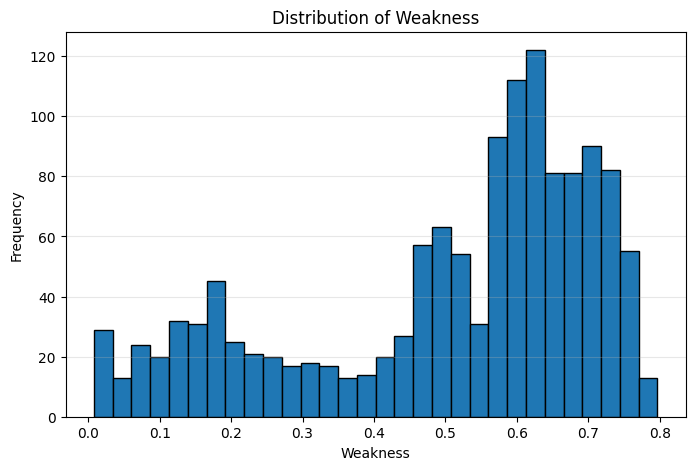

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(edges_df["Weakness"].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of Weakness")
plt.xlabel("Weakness")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()



In [9]:
edges_df.to_csv(os.path.join(data_path, 'interlocks', 'interlock_edges.csv'), index=False)
nodes_df.to_csv(os.path.join(data_path, 'interlocks', 'interlock_nodes.csv'), index=False)


In [10]:
edges_df.nlargest(10, "Weakness")

,Year,AffiliationId_1,Institution_1,AffiliationId_2,Institution_2,InterlockCount,BoardSize_1,BoardSize_2,WeightNorm,Weakness,Source,Target,Weight,EdgeEntropyBits
1141,2013,29957033,Pennsylvania State System Of Higher Education,72816309,Drexel University,1,20,43,0.015873,0.796875,29957033,72816309,0.015873,2.273198
1193,2013,103531236,Boston College,161515732,University Of St Thomas Minnesota,1,54,49,0.009709,0.791518,103531236,161515732,0.009709,3.122520
1131,2013,7863295,Villanova University,72816309,Drexel University,1,32,43,0.013333,0.787500,7863295,72816309,0.013333,1.557705
1219,2013,160856358,University Of San Diego,161515732,University Of St Thomas Minnesota,1,32,49,0.012346,0.787500,160856358,161515732,0.012346,2.758918
1123,2013,5388228,University Of Rochester,63966007,Massachusetts Institute Of Technology,1,48,72,0.008333,0.783482,5388228,63966007,0.008333,3.522025
1183,2013,102179633,New School,164389053,Fordham University,1,41,37,0.012821,0.780804,102179633,164389053,0.012821,2.575301
1132,2013,7863295,Villanova University,204465549,Washington University,1,32,54,0.011628,0.778125,7863295,204465549,0.011628,1.993929
947,2010,63966007,Massachusetts Institute Of Technology,102179633,New School,1,49,51,0.010000,0.777273,63966007,102179633,0.010000,2.760443
1208,2013,142823887,St Johns University,161515732,University Of St Thomas Minnesota,1,28,49,0.012987,0.775446,142823887,161515732,0.012987,2.739110
903,2010,1925986,Loyola University Chicago,35566140,Loyola Marymount University,1,47,41,0.011364,0.774545,1925986,35566140,0.011364,2.826604
